# CS398: Prg 4
### Eric Zander

> Conditional GAN using the CIFAR-10 dataset.

* References
    * CIFAR-10 dataset - https://www.cs.toronto.edu/~kriz/cifar.html
    * Conditional GAN Example (Keras) - https://keras.io/examples/generative/conditional_gan/
    * CIFAR GAN Example (Machine Learning Mastery) - https://machinelearningmastery.com/how-to-develop-a-generative-adversarial-network-for-a-cifar-10-small-object-photographs-from-scratch/

---

# Imports

In [1]:
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib

import tensorflow as tf
from tensorflow import keras
from keras import layers

---

# Setup

#### Define Parameters

In [2]:
input_shape = (32, 32, 3)  # Image shape
latent_dim = 256           # Dimensions of latent space
batch_size = 128           # Batch size per epoch

#### Prep Data

In [3]:
# Load data
(x_train, y_train), (x_test, y_test) = keras.datasets.cifar10.load_data()
img, labels = np.concatenate([x_train, x_test]), np.concatenate([y_train, y_test])

# Normalize images and reshape to add channel dimension
img = img.astype("float32") / 255
img = np.reshape(img, (-1, 32, 32, 3))

# One hot encode labels
classes = ["airplane", "automobile", "bird", "cat", "deer",
           "dog", "frog", "horse", "ship", "truck"]
num_classes = len(classes)
labels = keras.utils.to_categorical(labels, num_classes)

# Save as dataset
dataset = tf.data.Dataset.from_tensor_slices((img, labels))
dataset = dataset.shuffle(buffer_size=512)
dataset = dataset.batch(batch_size)

#### Vis

In [4]:
def show_img(img, image_no, original=False):
    label = classes[np.argmax(labels[im_no])]
    plt.imshow(img[im_no])
    
    if original:
        plt.title(f"Image No. {im_no} ({label})")
    else:
        plt.title(f"Image No. {im_no}")
    plt.show()

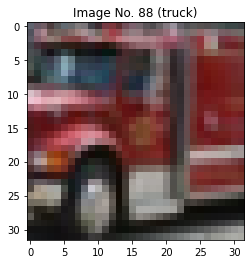

In [5]:
# Select image number
im_no = 88

# Visualize
show_img(img, im_no, original=True)

---

# GAN Definition

In [97]:
class ConditionalGAN(keras.Model):
    """
    Creates and maintains a discriminator and generator based on input characteristics.
    The architecture of these models is tailored to the CIFAR-10 dataset.
    
    After training, generator can create novel images that blend classes.
    """
    def __init__(self, input_shape, num_classes, latent_dim,
                 generator=None, discriminator=None, verbose=False):
        # Initialize keras model
        super(ConditionalGAN, self).__init__()
        
        # Save number of classes, size of image, and dimensions of latent space
        self.num_classes = num_classes
        self.image_size = input_shape
        self.latent_dim = latent_dim
        
        # Create discriminator if not provided
        if discriminator is None:
            self.discriminator = self._create_discriminator(input_shape, verbose)
        else:
            self.discriminator = discriminator
            
        # Create generator if not provided
        if generator is None:
            self.generator = self._create_generator(input_shape, verbose)
        else:
            self.generator = generator
        
        # Prepare to track loss during training
        self.gen_loss_tracker = keras.metrics.Mean(name="generator_loss")
        self.disc_loss_tracker = keras.metrics.Mean(name="discriminator_loss")

    @property
    def metrics(self):
        """
        Metrics for tracking loss during training
        """
        return [self.gen_loss_tracker, self.disc_loss_tracker]

    def compile(self, d_optimizer, g_optimizer, loss_fn):
        """
        Defines discriminator and generator optimizer and loss
        """
        super(ConditionalGAN, self).compile()
        
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        
        self.loss_fn = loss_fn

    def train_step(self, data):
        """
        Trains both networks. Largely based on:
            https://keras.io/examples/generative/conditional_gan/
        """
        # Unpack the data.
        real_images, one_hot_labels = data

        # Add dummy dimensions to the labels so that they can be concatenated with
        # the images. This is for the discriminator.
        image_one_hot_labels = one_hot_labels[:, :, None, None]
        image_one_hot_labels = tf.repeat(
            image_one_hot_labels, repeats=[self.image_size[0] * self.image_size[1]]
        )
        image_one_hot_labels = tf.reshape(
            image_one_hot_labels, (-1, self.image_size[0], self.image_size[1], num_classes)
        )

        # Sample random points in the latent space and concatenate the labels.
        # This is for the generator.
        batch_size = tf.shape(real_images)[0]
        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))
        random_vector_labels = tf.concat([random_latent_vectors, one_hot_labels], axis=1)

        # Decode the noise (guided by labels) to fake images.
        generated_images = self.generator(random_vector_labels)

        # Combine them with real images. Note that we are concatenating the labels
        # with these images here.
        fake_image_and_labels = tf.concat([generated_images, image_one_hot_labels], -1)
        real_image_and_labels = tf.concat([real_images, image_one_hot_labels], -1)
        combined_images = tf.concat(
            [fake_image_and_labels, real_image_and_labels], axis=0
        )

        # Assemble labels discriminating real from fake images.
        labels = tf.concat(
            [tf.ones((batch_size, 1)), tf.zeros((batch_size, 1))], axis=0
        )

        # Train the discriminator.
        with tf.GradientTape() as tape:
            predictions = self.discriminator(combined_images)
            d_loss = self.loss_fn(labels, predictions)
        grads = tape.gradient(d_loss, self.discriminator.trainable_weights)
        self.d_optimizer.apply_gradients(
            zip(grads, self.discriminator.trainable_weights)
        )

        # Sample random points in the latent space.
        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))
        random_vector_labels = tf.concat(
            [random_latent_vectors, one_hot_labels], axis=1
        )

        # Assemble labels that say "all real images".
        misleading_labels = tf.zeros((batch_size, 1))

        # Train the generator
        with tf.GradientTape() as tape:
            fake_images = self.generator(random_vector_labels)
            fake_image_and_labels = tf.concat([fake_images, image_one_hot_labels], -1)
            predictions = self.discriminator(fake_image_and_labels)
            g_loss = self.loss_fn(misleading_labels, predictions)
        grads = tape.gradient(g_loss, self.generator.trainable_weights)
        self.g_optimizer.apply_gradients(zip(grads, self.generator.trainable_weights))

        # Monitor loss.
        self.gen_loss_tracker.update_state(g_loss)
        self.disc_loss_tracker.update_state(d_loss)
        return {
            "g_loss": self.gen_loss_tracker.result(),
            "d_loss": self.disc_loss_tracker.result(),
        }
    
    # Helpers
    
    def _create_discriminator(self, input_shape, verbose):
        """
        Creates the discriminator with convolutional layers and aggressive downsampling
        """
        # Update channels of input shape to represent each classes
        in_shape = list(input_shape)
        in_shape[-1] = in_shape[-1] + self.num_classes
        in_shape = tuple(in_shape)
        
        # Create discriminator
        discriminator = keras.Sequential(
            [
                # One 64 filter layer
                layers.Conv2D(64, (3, 3), padding="same", input_shape=in_shape),
                layers.LeakyReLU(alpha=0.2),
                # One 128 filter layer
                layers.Conv2D(128, (3, 3), strides=(2, 2), padding="same"),
                layers.LeakyReLU(alpha=0.2),
                # One 256 filter layer
                layers.Conv2D(256, (3, 3), strides=(2, 2), padding="same"),
                layers.LeakyReLU(alpha=0.2),
                # Classifier (with dropout)
                layers.Flatten(),
                layers.Dropout(0.4),
                layers.Dense(1, activation='sigmoid'),
            ],
            name="discriminator",
        )
        
        if verbose:
            discriminator.summary()
        
        return discriminator
    
    def _create_generator(self, input_shape, verbose):
        """
        Creates the generator with layers for upsampling
        """
        # Set number of generator channels
        gen_channels = self.num_classes + self.latent_dim
        num_nodes = 4

        # Create generator
        generator = keras.Sequential(
            [
                keras.layers.InputLayer((gen_channels,)),
                # Start with 4 x 4 x latent_dims
                layers.Dense(num_nodes * num_nodes * gen_channels),
                layers.LeakyReLU(alpha=0.2),
                layers.Reshape((num_nodes, num_nodes, gen_channels)),
                # Upsample to 8x8
                layers.Conv2DTranspose(256, (4, 4), strides=(2, 2), padding="same"),
                layers.LeakyReLU(alpha=0.2),
                # Upsample to 16x16
                layers.Conv2DTranspose(128, (4, 4), strides=(2, 2), padding="same"),
                layers.LeakyReLU(alpha=0.2),
                # Upsample to 32x32
                layers.Conv2DTranspose(64, (4, 4), strides=(2, 2), padding="same"),
                layers.LeakyReLU(alpha=0.2),
                # Output layer w/ 3 channels
                layers.Conv2D(3, (num_nodes, num_nodes), padding="same", activation="sigmoid"),
            ],
            name="generator",
        )
        
        if verbose:
            generator.summary()
        
        return generator

---

# Training GAN

In [23]:
# Create the GAN
cond_gan = ConditionalGAN(input_shape, num_classes, latent_dim, verbose=True)

Model: "discriminator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_5 (Conv2D)           (None, 32, 32, 64)        7552      
                                                                 
 leaky_re_lu_8 (LeakyReLU)   (None, 32, 32, 64)        0         
                                                                 
 conv2d_6 (Conv2D)           (None, 16, 16, 128)       73856     
                                                                 
 leaky_re_lu_9 (LeakyReLU)   (None, 16, 16, 128)       0         
                                                                 
 conv2d_7 (Conv2D)           (None, 8, 8, 256)         295168    
                                                                 
 leaky_re_lu_10 (LeakyReLU)  (None, 8, 8, 256)         0         
                                                                 
 flatten_1 (Flatten)         (None, 16384)           

In [24]:
# Compile the models with Adam optimizers
cond_gan.compile(
    d_optimizer=keras.optimizers.Adam(learning_rate=0.0001, beta_1=0.5),
    g_optimizer=keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5),
    loss_fn=keras.losses.BinaryCrossentropy(),#from_logits=True),
)

In [36]:
# Fit
cond_gan.fit(dataset, epochs=300)

Epoch 1/100
469/469 [==============================] - 42s 89ms/step - g_loss: 0.7478 - d_loss: 0.6704
Epoch 2/100
469/469 [==============================] - 42s 90ms/step - g_loss: 0.7467 - d_loss: 0.6706
Epoch 3/100
469/469 [==============================] - 43s 92ms/step - g_loss: 0.7487 - d_loss: 0.6701
Epoch 4/100
469/469 [==============================] - 47s 100ms/step - g_loss: 0.7494 - d_loss: 0.6703
Epoch 5/100
469/469 [==============================] - 45s 97ms/step - g_loss: 0.7487 - d_loss: 0.6704
Epoch 6/100
469/469 [==============================] - 48s 102ms/step - g_loss: 0.7468 - d_loss: 0.6688
Epoch 7/100
469/469 [==============================] - 47s 100ms/step - g_loss: 0.7506 - d_loss: 0.6695
Epoch 8/100
469/469 [==============================] - 46s 99ms/step - g_loss: 0.7502 - d_loss: 0.6691
Epoch 9/100
469/469 [==============================] - 45s 96ms/step - g_loss: 0.7483 - d_loss: 0.6688
Epoch 10/100
469/469 [==============================] - 45s 95ms/step 

> The following results in the submission were created after 300 epochs of training.

#### Save Models

In [101]:
# Save generator
#cond_gan.generator.save("models/generator")

# Save discriminator
#cond_gan.discriminator.save("models/discriminator")

INFO:tensorflow:Assets written to: models/generator\assets
INFO:tensorflow:Assets written to: models/discriminator\assets


---

# Image Generation

#### Define Interpolating Function

In [37]:
def interpolate_class(trained_gen, first_class, second_class, num_interpolation=10):
    """
    Creates the given number of images by interpolating between the two
    given classes
    """
    # Sample noise for the interpolation.
    interpolation_noise = tf.random.normal(shape=(1, latent_dim))
    interpolation_noise = tf.repeat(interpolation_noise, repeats=num_interpolation)
    interpolation_noise = tf.reshape(interpolation_noise, (num_interpolation, latent_dim))
    
    # Convert the start and end labels to one-hot encoded vectors.
    first_label = keras.utils.to_categorical([first_class], num_classes)
    second_label = keras.utils.to_categorical([second_class], num_classes)
    first_label = tf.cast(first_label, tf.float32)
    second_label = tf.cast(second_label, tf.float32)

    # Calculate the interpolation vector between the two labels.
    percent_second_label = tf.linspace(0, 1, num_interpolation)[:, None]
    percent_second_label = tf.cast(percent_second_label, tf.float32)
    interpolation_labels = (
        first_label * (1 - percent_second_label) + second_label * percent_second_label
    )

    # Combine the noise and the labels and run inference with the generator.
    noise_and_labels = tf.concat([interpolation_noise, interpolation_labels], 1)
    fake = trained_gen.predict(noise_and_labels)
    
    return fake  # Return fake images

#### Class Aliases

In [38]:
for i, class_type in enumerate(classes):
    print(f"{i} : {class_type}")

0 : airplane
1 : automobile
2 : bird
3 : cat
4 : deer
5 : dog
6 : frog
7 : horse
8 : ship
9 : truck


> Choose indices of class to interpolate

#### Generate Images

In [39]:
def show_gallery(fake_img):
    fig, axes = plt.subplots(2, 5, figsize=(12, 6), sharex=True, sharey=True)
    
    for i, ax in enumerate(axes.reshape(-1)):
        ax.imshow(fake_img[i])
        ax.set_xticks([])
        ax.set_yticks([])
    
    plt.subplots_adjust(wspace=0.1, hspace=0.01)
    
    plt.show()

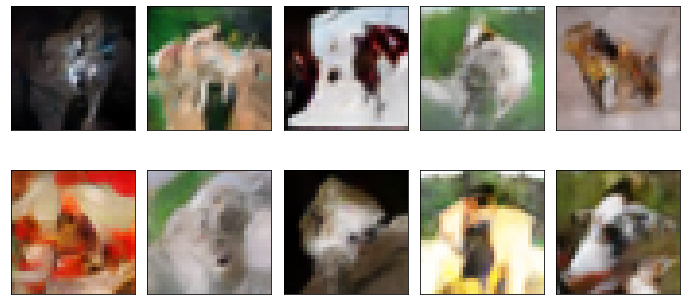

In [122]:
fake_img = interpolate_class(cond_gan.generator, 5, 5)
show_gallery(fake_img)

In [81]:
# Save image
im_name = "frog_truck6.png"
im_ind = 7
#matplotlib.image.imsave(f"img/{im_name}.png", fake_img[im_ind])

#### Load Gallery

> Below is a gallery of some images created using the trained generator.

In [2]:
all_img = []
all_names = []

for root, dirs, files in os.walk("img", topdown=False):
    for file in files:
        im_file = os.path.join(root, file)
        all_img.append(matplotlib.image.imread(im_file))
        all_names.append(file.split(".")[0])

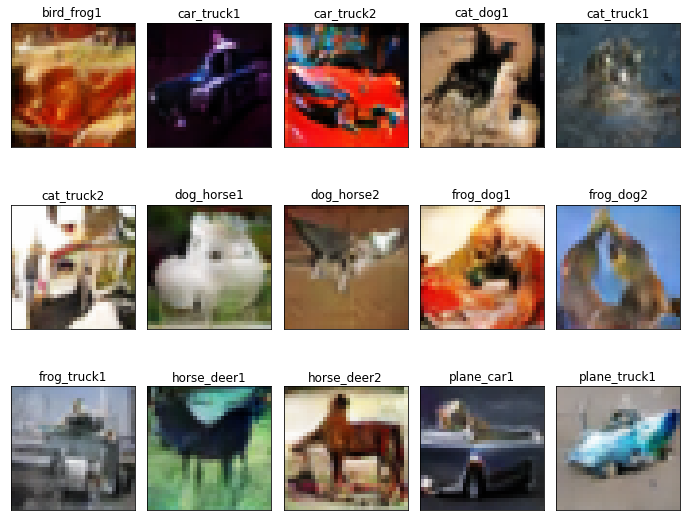

In [3]:
fig, axes = plt.subplots(3, 5, figsize=(12, 10), sharex=True, sharey=True)

for i, ax in enumerate(axes.reshape(-1)):
    ax.imshow(all_img[i])
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title(all_names[i])

plt.subplots_adjust(wspace=0.1, hspace=0.01)

plt.show()

#### Friend's Interpretations

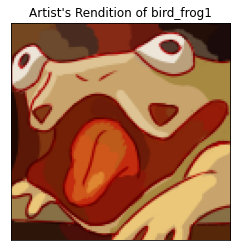

In [4]:
bird_frog1 = matplotlib.image.imread("artists_rendition1.png")
plt.imshow(bird_frog1)
plt.title("Artist's Rendition of bird_frog1")
plt.xticks([])
plt.yticks([])
plt.show()

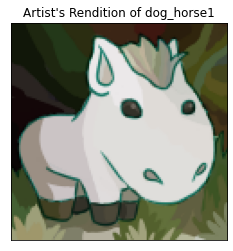

In [5]:
bird_frog1 = matplotlib.image.imread("artists_rendition2.png")
plt.imshow(bird_frog1)
plt.title("Artist's Rendition of dog_horse1")
plt.xticks([])
plt.yticks([])
plt.show()

#### Conclusion

> The results are limited due to both the variety and resolution of the data as well as issues with the discriminator overpowering the generator. Reducing the complexity of the architecture, adding leaky ReLU, adding dropout, and lowering the learning rate of the discriminator helped deal with the latter, but a more targeted approach to a more specific problem could join further experimentation to afford cleaner results.